<a href="https://colab.research.google.com/github/roo-21/facepainting-gan/blob/main/face_paint_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_visible_devices(gpus, 'GPU')

In [4]:
images=np.load('/drive/MyDrive/Datasets/images/images.npy')
images=(images/127.5)-1
images.shape

(6200, 128, 128, 3)

In [5]:
images_blur=np.load('/drive/MyDrive/Datasets/images/images_blurred.npy') #images where the face is kept un-blurred while everything else is blurred
images_blur=(images_blur/127.5)-1
images_blur.shape

(6095, 128, 128, 3)

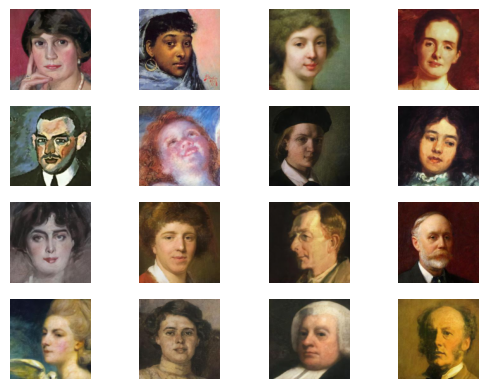

In [6]:
i=0
for j in np.random.randint(0,images.shape[0],16):
    plt.subplot(4, 4,i+1)
    plt.imshow((images[j]+1)/2)
    plt.axis("off")
    i+=1
plt.show()

In [7]:
img_shape=images.shape[1:]
latent_dim=100
img_shape

(128, 128, 3)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, InstanceNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Dropout, Flatten, Reshape
from keras.optimizers import Adam

In [9]:
def create_discriminator(in_shape=img_shape):

    disc=Sequential()

    disc.add(Conv2D(64,(5,5), padding='same', input_shape=in_shape))
    disc.add(LeakyReLU())
    disc.add(Dropout(0.2))

    disc.add(Conv2D(128,(5,5),padding='same'))
    disc.add(LeakyReLU())
    disc.add(Dropout(0.2))

    disc.add(Flatten())
    disc.add(Dense(1,activation='sigmoid'))

    disc.compile(loss='binary_crossentropy',optimizer=Adam(0.0001,0.85),metrics=['accuracy'])

    return disc

In [10]:
def create_generator(latent_dim=latent_dim):

    noise_shape=(latent_dim,)

    gen=Sequential()

    gen.add(Dense((32*32*256), input_shape=noise_shape))
    gen.add(LeakyReLU())

    gen.add(Reshape((32,32,256)))

    gen.add(Conv2DTranspose(128,(5,5),strides=(1,1),padding='same'))
    gen.add(LeakyReLU())
    gen.add(InstanceNormalization())

    gen.add(Conv2DTranspose(64,(5,5),strides=(2,2), padding='same'))
    gen.add(LeakyReLU())
    gen.add(InstanceNormalization())

    gen.add(Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',activation='tanh'))

    return gen

In [11]:
def create_gan(generator, discriminator):
  discriminator.trainable = False

  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  model.compile(loss='binary_crossentropy',optimizer=Adam(0.0001,0.89))
  return model

In [12]:
def real_samples(dataset1,dataset2,num_samples):
  idx1=np.random.randint(0,dataset1.shape[0],int(num_samples*0.95))
  idx2=np.random.randint(0,dataset2.shape[0],num_samples-int(num_samples*0.95))
  x1=dataset1[idx1]
  x2=dataset2[idx2]

  x=np.concatenate((x1,x2),axis=0)
  y=np.ones((num_samples,1))

  return x,y

In [13]:
def generate_latent_points(latent_dim,num_samples):
  x_input = np.random.randn(num_samples,latent_dim)
  return x_input

In [14]:
def generate_fake_samples(generator,latent_dim,num_samples):
  x_input=generate_latent_points(latent_dim,num_samples)
  x=generator.predict(x_input)
  y=np.zeros((num_samples,1))
  return x,y

In [15]:
def train(g_model, d_model, gan_model, dataset1, dataset2, latent_dim, n_epochs=10,batch_size=32):

  batch_per_epoch=int(dataset1.shape[0]/batch_size)
  half_batch=int(batch_size/2)

  #lists to store discriminator and gan losses
  d_losses=[]
  g_losses=[]

  print(f"{n_epochs} epochs and {batch_per_epoch} batches of size {batch_size} each epoch")
  for i in range(n_epochs):
    for j in range(batch_per_epoch):

      x_real,y_real=real_samples(dataset1,dataset2,half_batch) # half the batch size of real images are taken during each batch and also they are labelled 1
      x_fake,y_fake=generate_fake_samples(g_model,latent_dim,half_batch) # half the batch size of fake images are taken as well and the are labelled 0
      x_train=np.concatenate((x_real,x_fake),axis=0) # the real and fake images are concatenated
      y_train=np.concatenate((y_real,y_fake),axis=0) # and the labels too

      idx=np.random.permutation(x_train.shape[0]) # taking indices of the image array in random order
      x_train=x_train[idx] #shuffling the images and labels using the above order
      y_train=y_train[idx]

      d_loss,_=d_model.train_on_batch(x_train,y_train) #training the discriminator

      x_gan = generate_latent_points(latent_dim,batch_size) # latent vectors are generated for the gan model
      y_gan=np.ones((batch_size,1)) #they are all labelled 1

      g_loss = gan_model.train_on_batch(x_gan,y_gan) #training gan using the above data

      print('Epoch %d/%d, Batch %d/%d, d=%.3f g=%.3f' % (i+1, n_epochs, j+1, batch_per_epoch, d_loss, g_loss))

    # appending discriminator loss and generator loss to the list after each epoch
    d_losses.append(d_loss)
    g_losses.append(g_loss)

  g_model.save('face_painterdc1.h5')
  return d_losses,g_losses

In [16]:
discriminator=create_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 128)     0         
                                                                 
 dropout_1 (Dropout)         (None, 128, 128, 128)     0         
                                                                 
 flatten (Flatten)           (None, 2097152)           0

In [17]:
generator=create_generator(latent_dim)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 262144)            26476544  
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 262144)            0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 128)       819328    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 64)        204864    
 Transpose)                                           

In [18]:
vec0=np.random.randn(1,latent_dim)
img=generator.predict(vec0)

1/1 [==============================] - 2s 2s/step


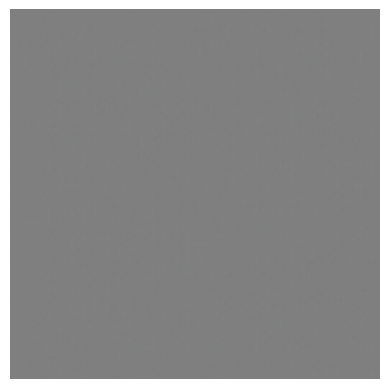

In [19]:
plt.imshow((np.array(img[0])+1)/2)
plt.axis('off')
plt.show()

In [20]:
dcgan=create_gan(generator, discriminator)

In [21]:
epoch=100
batch_size=64

In [22]:
d_loss,g_loss=train(generator,discriminator,dcgan,images,images_blur,latent_dim,epoch,batch_size)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step
Epoch 74/100, Batch 93/96, d=0.438 g=2.127
1/1 [==============================] - 0s 15ms/step
Epoch 74/100, Batch 94/96, d=0.465 g=1.747
1/1 [==============================] - 0s 16ms/step
Epoch 74/100, Batch 95/96, d=0.450 g=1.386
1/1 [==============================] - 0s 16ms/step
Epoch 74/100, Batch 96/96, d=0.382 g=1.577
1/1 [==============================] - 0s 16ms/step
Epoch 75/100, Batch 1/96, d=0.548 g=2.023
1/1 [==============================] - 0s 16ms/step
Epoch 75/100, Batch 2/96, d=0.392 g=2.035
1/1 [==============================] - 0s 16ms/step
Epoch 75/100, Batch 3/96, d=0.463 g=1.904
1/1 [==============================] - 0s 15ms/step
Epoch 75/100, Batch 4/96, d=0.412 g=1.635
1/1 [==============================] - 0s 16ms/step
Epoch 75/100, Batch 5/96, d=0.376 g=1.813
1/1 [==============================] - 0s 16ms/step
Epoch 75/100, Batch 6/96, d=0.382 g=1.743
1/1 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 100/100, Batch 96/96, d=0.360 g=3.008


In [23]:
img=generator.predict(vec0)

1/1 [==============================] - 0s 20ms/step


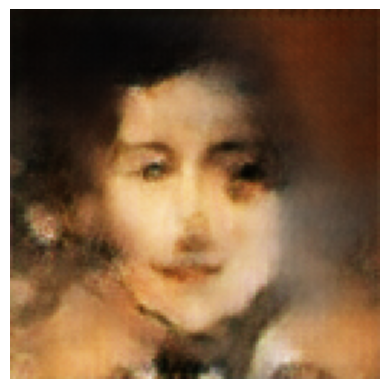

In [24]:
plt.imshow((np.array(img[0])+1)/2)
plt.axis('off')
plt.show()

In [25]:
num_images=16
x_gen=generate_latent_points(latent_dim,num_images)
gen_images=generator.predict(x_gen) # generating 16 images

1/1 [==============================] - 0s 401ms/step


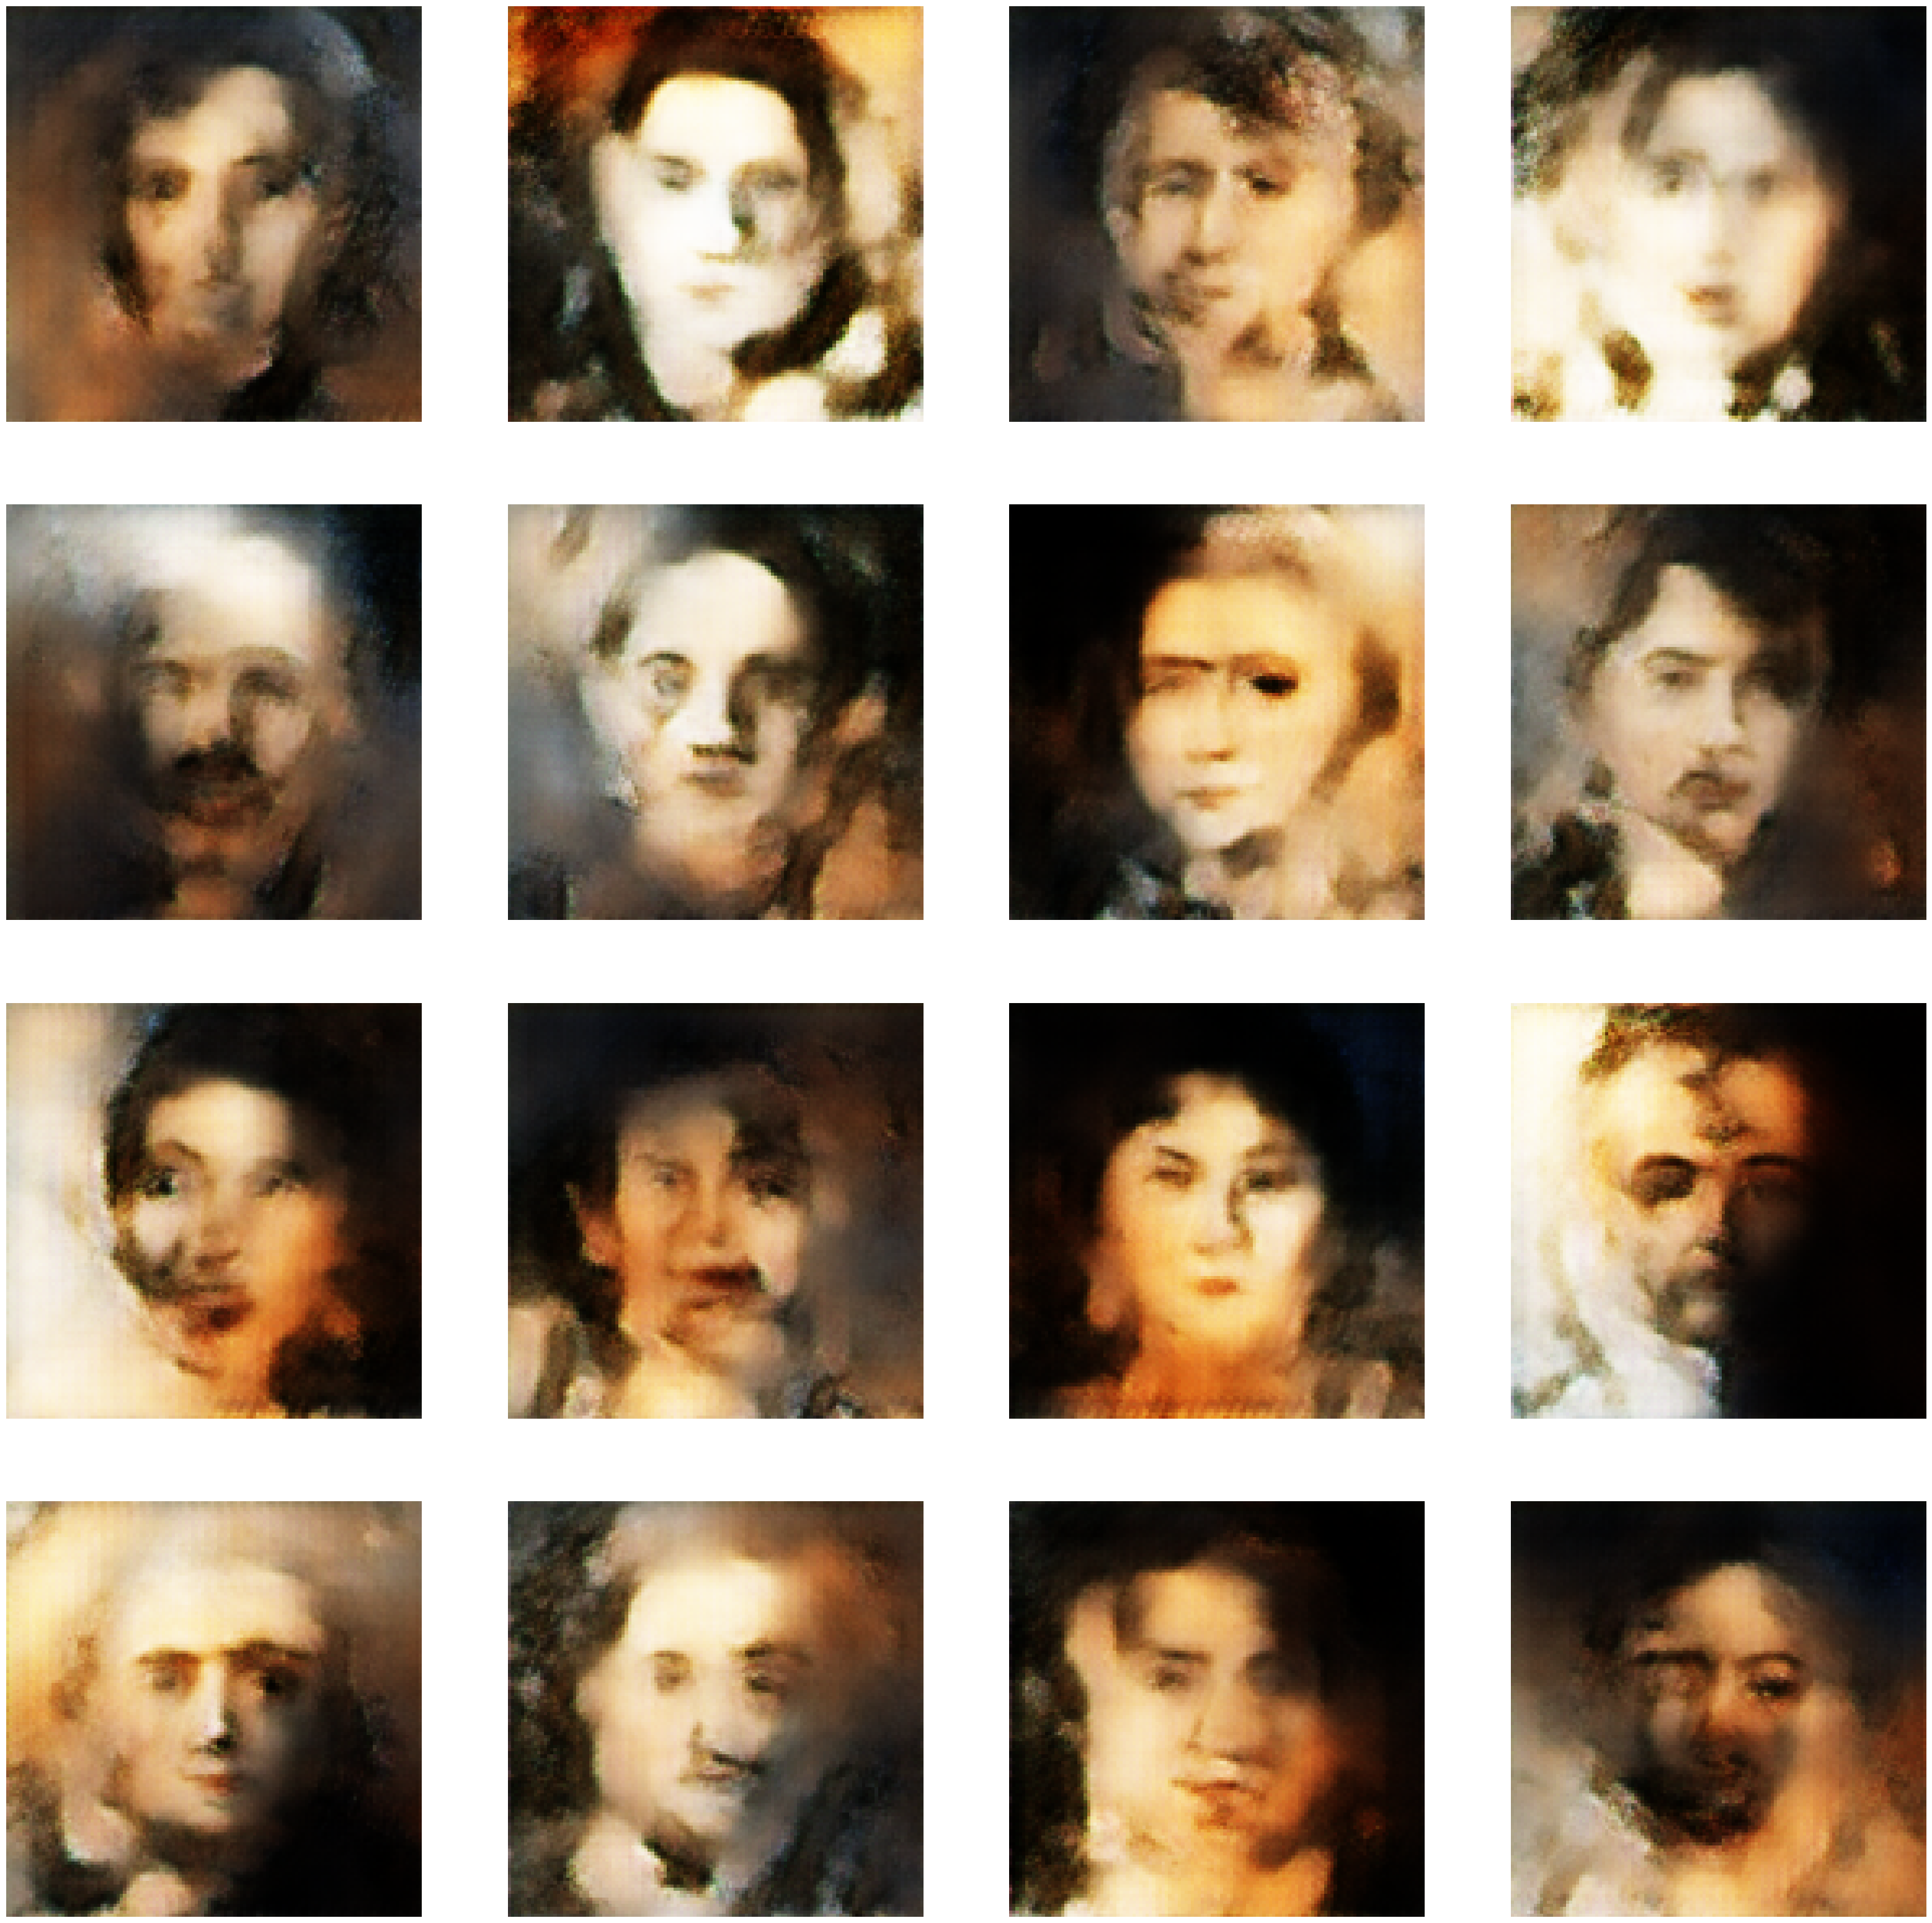

In [26]:
plt.figure(figsize=(40,40))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow((gen_images[i]+1)/2)
plt.show()

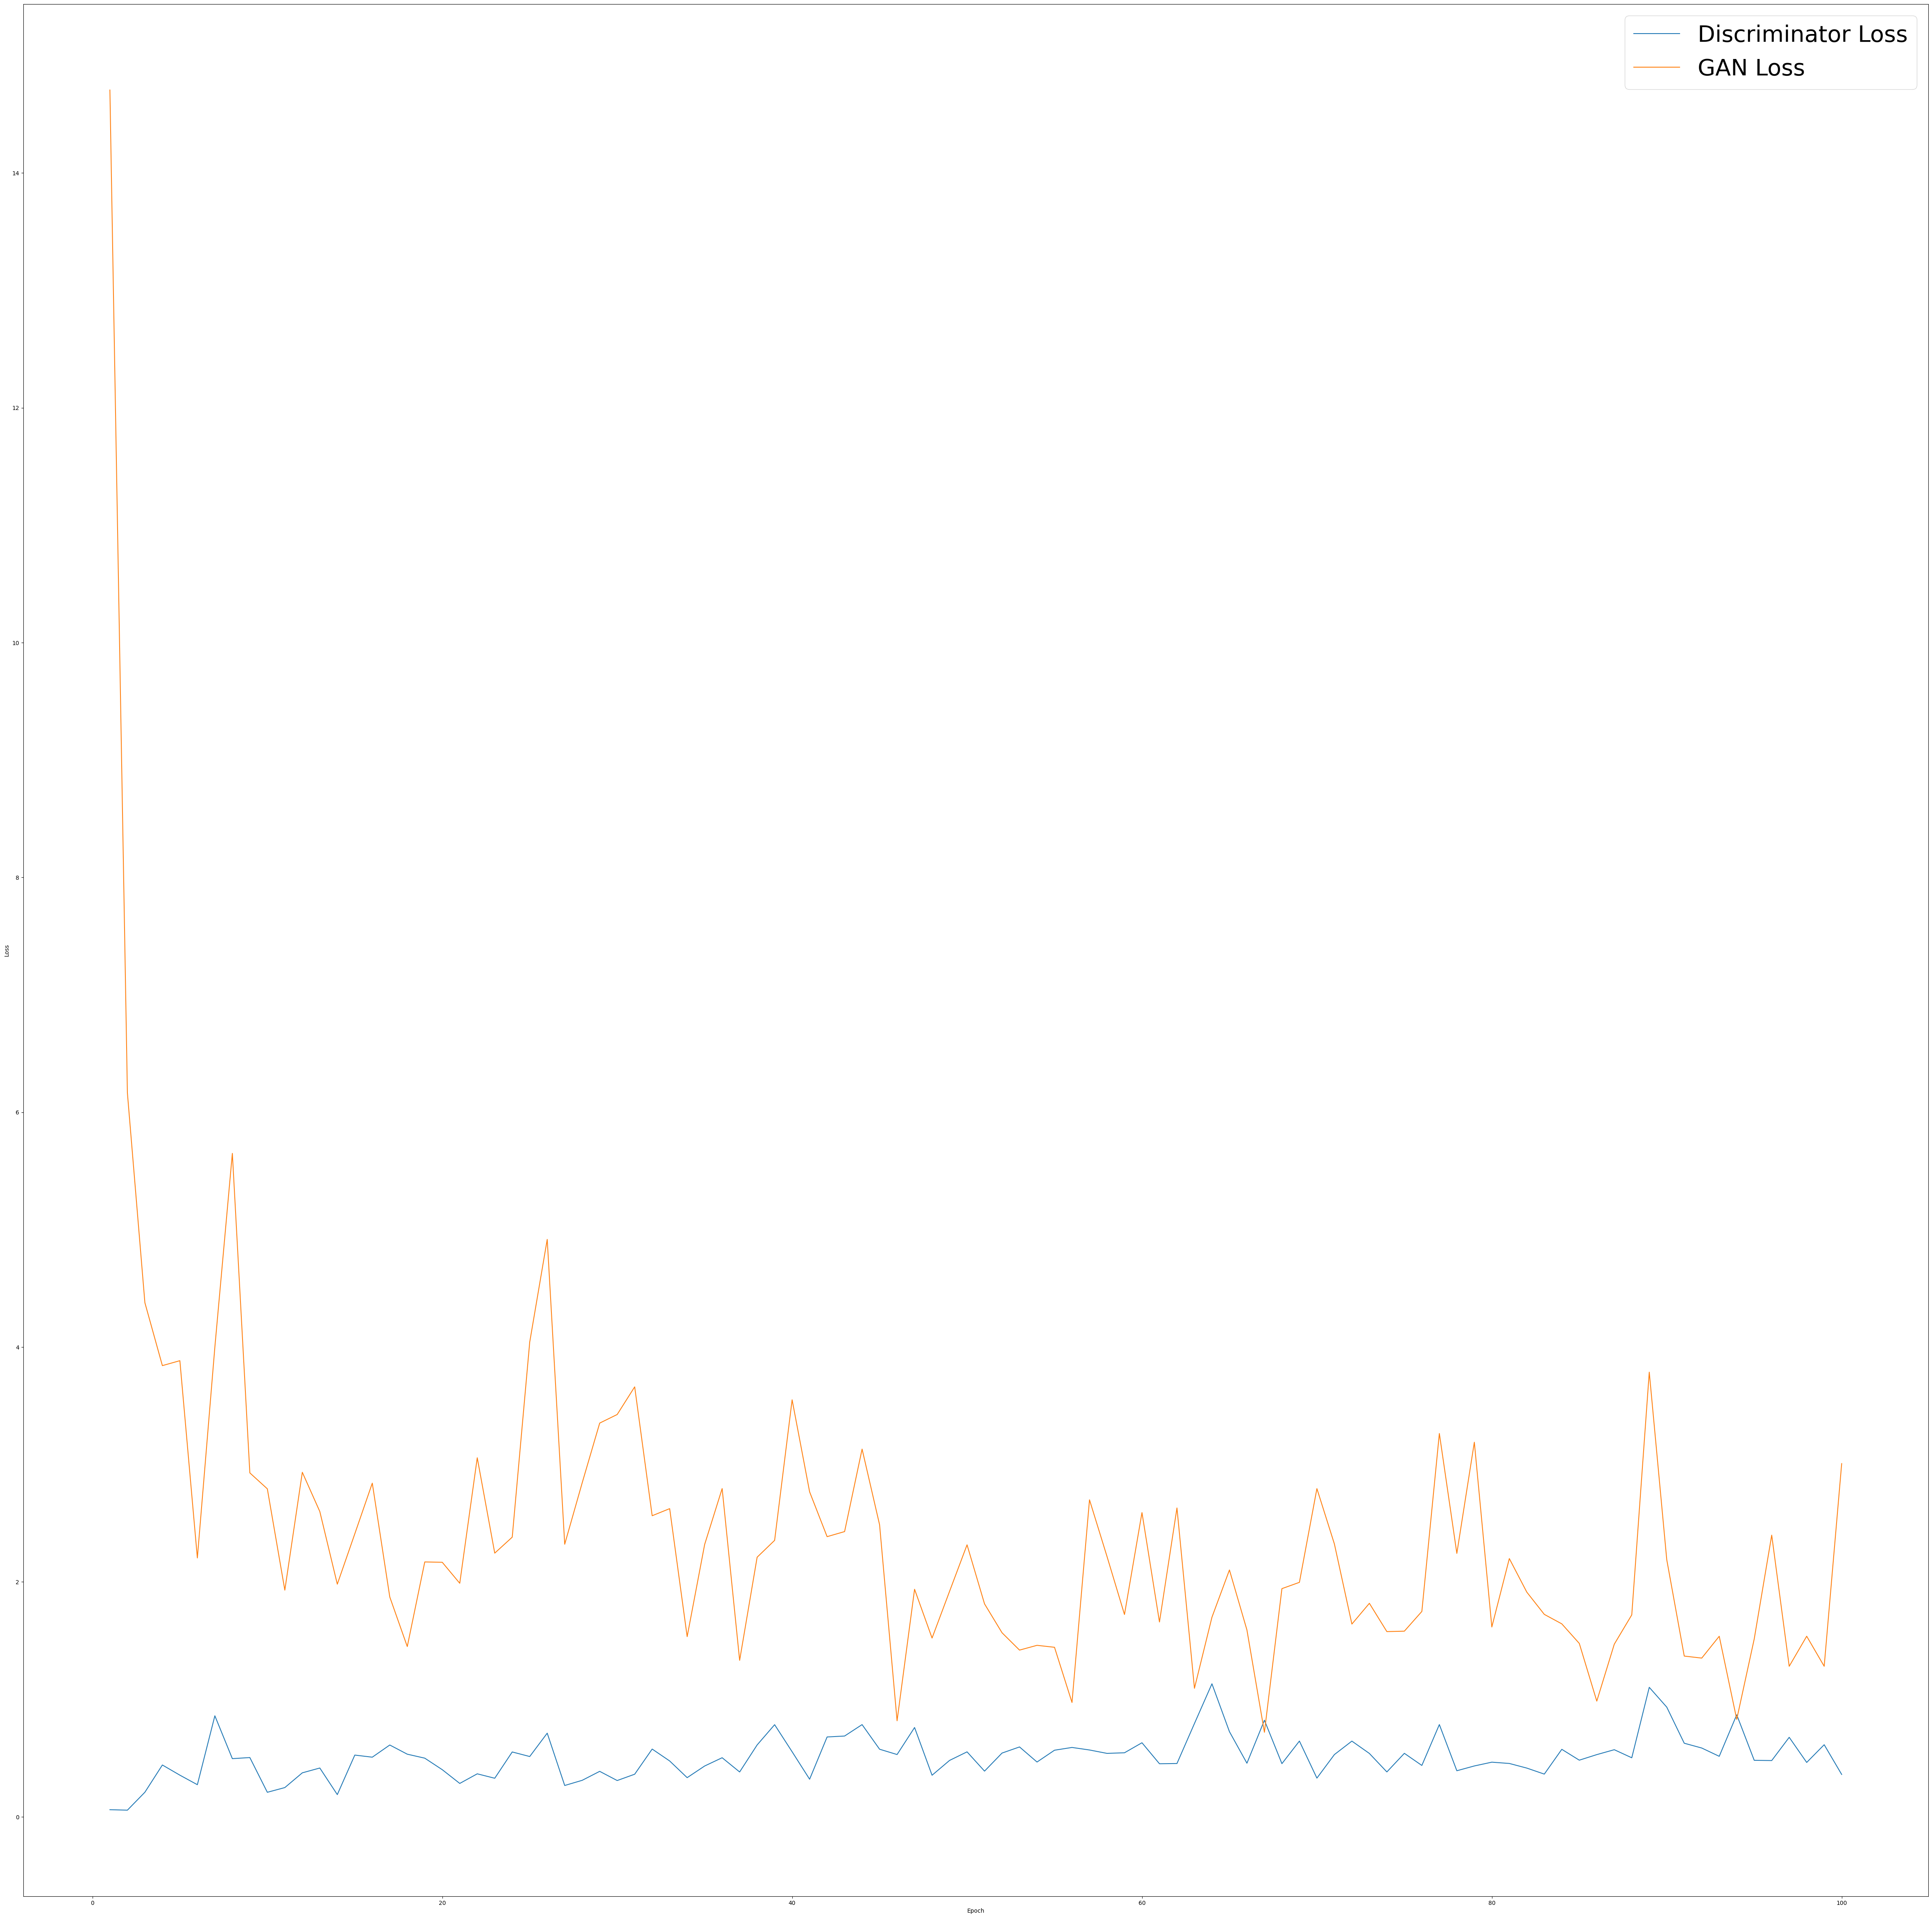

In [27]:
x=np.arange(1,epoch+1)
plt.figure(figsize=(60,60))
plt.plot(x,d_loss,label='Discriminator Loss')
plt.plot(x,g_loss,label='GAN Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=40)
plt.show()